Assignment 3: Variational Autoencoders

Theory Questions:

Q1: Why is the KL Divergence term important in the VAE loss function?
The KL Divergence term reshapes the latent space so that it forms a continuous, consistent, smooth distribution. This allows for interpolation that changes gradually instead of sporadically as well as better generalization to similar distributions. Without the KL divergence term the latent space would be fragmented and random sampling would be less coherent.

Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?
The reparameterization trick rewrites direct sampling as a differentiable function so that the gradient can be computed. This allows μ and σ to be adjusted in order to minimize the loss function and regularize the latent space.

Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?
Instead of a single latent vector, the VAE learns to encode the input as a distribution of possible latent vectors in order to capture the uncertainty and variability in the data. This allows for more varied generation as well as the ability to interpolate smoothly between images. The model will generalize better to images that have ambiguous features as there would be multiple representations for a given input by using a probabilistic latent space rather than a fixed latent space.

Q4: What role does KL Divergence play in ensuring a smooth latent space? 
KL Divergence is used to measure the difference between two probability distributions. In the VAE loss function this calculates the difference between the learned latent distribution and the prior which is most often a Gaussian distribution. By minimizing divergence we can ensure that similar outputs will be mapped to similar points in latent space, thus regularizing the learned distribution.

In [3]:
!pip install matplotlib

  Using cached matplotlib-3.10.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.0-cp313-cp313-macosx_11_0_arm64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 6.5 MB/s eta 0:00:00a 0:00:01
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Task 1: Fully Connected VAE vs Convolutional VAE

In [25]:
# Fully Connected VAE
class FCVAE(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=400, latent_dim=20):
        super(FCVAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))
    
    def forward(self, x):
        x = x.view(-1, 3072)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        recon = recon.view(-1, 3, 32, 32)
        return recon, mu, logvar

In [6]:
# Convolutional VAE
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvVAE, self).__init__()

        #Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)   # -> (32,16,16)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # -> (64,8,8)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # -> (128,4,4)
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        #Decoder
        self.fc_dec = nn.Linear(latent_dim, 128*4*4)
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # -> (64,8,8)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)   # -> (32,16,16)
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)    # -> (3,32,32)
    
    def encode(self, x):
        h = torch.relu(self.enc_conv1(x))
        h = torch.relu(self.enc_conv2(h))
        h = torch.relu(self.enc_conv3(h))
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc_dec(z))
        h = h.view(-1, 128, 4, 4)
        h = torch.relu(self.dec_conv1(h))
        h = torch.relu(self.dec_conv2(h))
        h = torch.sigmoid(self.dec_conv3(h))
        return h
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [7]:
# Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [8]:
# Load CIFAR-10 dataset
transform = transforms.ToTensor()
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)

100.0%


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fc_vae = FCVAE().to(device)
conv_vae = ConvVAE().to(device)

optimizer_fc = optim.Adam(fc_vae.parameters(), lr=1e-3)
optimizer_conv = optim.Adam(conv_vae.parameters(), lr=1e-3)

#Function to train the models
def train_epoch(model, data_loader, optimizer, epoch, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(data_loader.dataset):.4f}')

#Train the models
print("Training Fully Connected VAE on CIFAR-10")
for epoch in range(1, 11):
    train_epoch(fc_vae, cifar_loader, optimizer_fc, epoch, device)
    
print("\nTraining Convolutional VAE on CIFAR-10")
for epoch in range(1, 11):
    train_epoch(conv_vae, cifar_loader, optimizer_conv, epoch, device)

Training Fully Connected VAE on CIFAR-10
Epoch 1, Loss: 1930.7215
Epoch 2, Loss: 1866.3772
Epoch 3, Loss: 1855.7054
Epoch 4, Loss: 1851.2158
Epoch 5, Loss: 1848.2113
Epoch 6, Loss: 1846.2004
Epoch 7, Loss: 1844.7250
Epoch 8, Loss: 1843.7730
Epoch 9, Loss: 1843.1134
Epoch 10, Loss: 1842.3761

Training Convolutional VAE on CIFAR-10
Epoch 1, Loss: 1930.5757
Epoch 2, Loss: 1854.4135
Epoch 3, Loss: 1843.2714
Epoch 4, Loss: 1839.6259
Epoch 5, Loss: 1837.3477
Epoch 6, Loss: 1836.5758
Epoch 7, Loss: 1835.5500
Epoch 8, Loss: 1834.8458
Epoch 9, Loss: 1834.3883
Epoch 10, Loss: 1833.9341


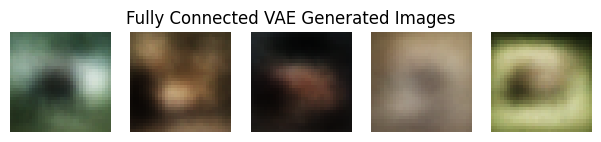

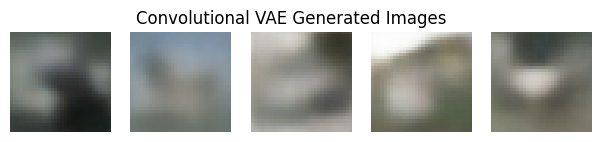

In [11]:
# Generates Images
def generate_images(model, latent_dim, num_images=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        generated = model.decode(z).cpu()
        if generated.dim() == 2:
            generated = generated.view(num_images, 3, 32, 32)
    return generated

# Shows Images
def show_images(images, title):
    num_images = images.size(0)
    fig, axs = plt.subplots(1, num_images, figsize=(num_images*1.5, 1.5))
    for i in range(num_images):
        axs[i].imshow(images[i].permute(1,2,0))
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()
    
fc_generated = generate_images(fc_vae, latent_dim=20, num_images=5)
conv_generated = generate_images(conv_vae, latent_dim=20, num_images=5)

show_images(fc_generated, "Fully Connected VAE Generated Images")
show_images(conv_generated, "Convolutional VAE Generated Images")

Task 2: Interpolate between two images

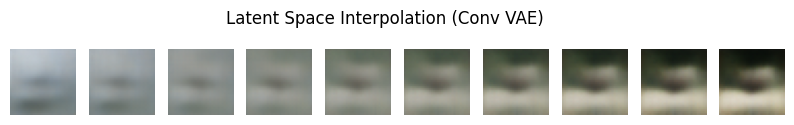

In [12]:
# Funciton to encode image, then generate interpolated vector, then decode
def interpolate_images(model, img1, img2, steps=10):
    model.eval()
    with torch.no_grad():
        mu1, _ = model.encode(img1.unsqueeze(0).to(device))
        mu2, _ = model.encode(img2.unsqueeze(0).to(device))
        z_interp = []
        for alpha in torch.linspace(0, 1, steps):
            z = mu1 * (1 - alpha) + mu2 * alpha
            z_interp.append(z)
        z_interp = torch.cat(z_interp, dim=0)
        recon_interp = model.decode(z_interp).cpu()
    return recon_interp

data_iter = iter(cifar_loader)
imgs, _ = next(data_iter)
img1 = imgs[0]
img2 = imgs[1]

interp_images = interpolate_images(conv_vae, img1, img2, steps=10)

fig, axs = plt.subplots(1, 10, figsize=(10, 1.5))
for i in range(10):
    axs[i].imshow(interp_images[i].permute(1,2,0))
    axs[i].axis('off')
plt.suptitle("Latent Space Interpolation (Conv VAE)")
plt.show()

In [ ]:
Task 3: VAE on CelebA dataset

In [13]:
# Convolutional VAE for 64x64 CelebA input
class CelebAVAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(CelebAVAE, self).__init__()
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)    
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)   
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  
        self.enc_conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) 
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        
        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 256*4*4)
        self.dec_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1) 
        self.dec_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  
        self.dec_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)   
        self.dec_conv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)    
    
    def encode(self, x):
        h = torch.relu(self.enc_conv1(x))
        h = torch.relu(self.enc_conv2(h))
        h = torch.relu(self.enc_conv3(h))
        h = torch.relu(self.enc_conv4(h))
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc_dec(z))
        h = h.view(-1, 256, 4, 4)
        h = torch.relu(self.dec_conv1(h))
        h = torch.relu(self.dec_conv2(h))
        h = torch.relu(self.dec_conv3(h))
        h = torch.sigmoid(self.dec_conv4(h))
        return h
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [ ]:
# Load the CelebA dataset
celeba_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])

celeba_dataset = datasets.CelebA(root='./data', split='train', download=True, transform=celeba_transform)
celeba_loader = torch.utils.data.DataLoader(celeba_dataset, batch_size=128, shuffle=True)

In [22]:
from torch.utils.data import Subset

# Use setset for efficiency
subset_indices = list(range(10000))
celeba_subset = Subset(celeba_dataset, subset_indices)

celeba_loader_subset = torch.utils.data.DataLoader(celeba_subset, batch_size=128, shuffle=True)

celeba_vae = CelebAVAE(latent_dim=100).to(device)
optimizer_celeba = optim.Adam(celeba_vae.parameters(), lr=1e-3)

print("Training CelebA VAE on subset")
for epoch in range(1, 11):
    train_epoch(celeba_vae, celeba_loader_subset, optimizer_celeba, epoch, device)


Training CelebA VAE on subset
Epoch 1, Loss: 7905.8161
Epoch 2, Loss: 7001.7738
Epoch 3, Loss: 6855.7206
Epoch 4, Loss: 6720.7791
Epoch 5, Loss: 6656.4425
Epoch 6, Loss: 6641.2892
Epoch 7, Loss: 6583.8700
Epoch 8, Loss: 6560.5532
Epoch 9, Loss: 6533.0450
Epoch 10, Loss: 6501.5375


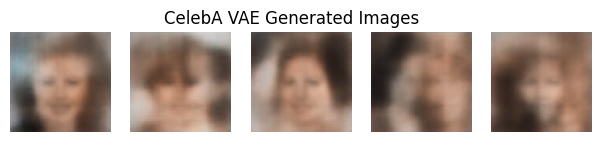

In [23]:
# Generate New Images
celeba_generated = generate_images(celeba_vae, latent_dim=100, num_images=5)
show_images(celeba_generated, "CelebA VAE Generated Images")

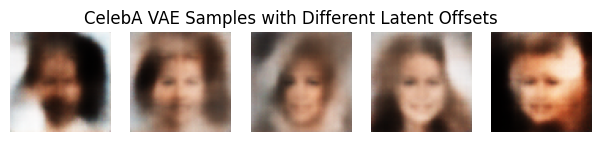

In [24]:
# Sample from different regions of the latent space
samples = []
offsets = torch.linspace(-2, 2, steps=5)
for offset in offsets:
    z = torch.randn(1, 100).to(device) + offset  
    with torch.no_grad():
        sample = celeba_vae.decode(z).cpu()
    samples.append(sample)
samples = torch.cat(samples, dim=0)
show_images(samples, "CelebA VAE Samples with Different Latent Offsets")

The results of the VAE samples with different latent offsets illustrates that shifting the latent vector changes different characteristics of the image. These variations demonstrate that the learned latent space encodes features such as hair color, face shape, and image contrast.